# **Section:** ALL K folds

In [1]:
import os
import itertools as it
import warnings
import time
import pickle

import numpy as np

import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns

import joblib

import pathlib

from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import DataConversionWarning
from sklearn.model_selection import (
    KFold, StratifiedKFold, train_test_split)

from sklearn import metrics

import tqdm

from libs.container import Container
from libs.nearest import nearest
from libs.experiment import WithAnotherExperiment, roc, metrics
from libs.precstar import  prec_star

warnings.simplefilter("ignore", category=DataConversionWarning)

/home/jbcabral/miniconda2/envs/howfar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.ranking module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
%%time

PATH = pathlib.Path(os.path.abspath(os.path.dirname("")))

DATA_PATH = PATH / "_data"

COLUMNS_NO_FEATURES = ['id', 'tile', 'cnt', 'ra_k', 'dec_k', 'vs_type', 'vs_catalog', 'cls'] 

path = "_data/full_scaled.pkl.bz2"

train_datas = {}

sample = pd.read_pickle(path)

# the features
X_columns = [c for c in sample.columns if c not in COLUMNS_NO_FEATURES]
y_column = "cls"

sample[X_columns] =  sample[X_columns].astype(np.float32)

data = Container({k: v for k, v in sample.groupby("tile")})

del sample

CPU times: user 13min 2s, sys: 4min 18s, total: 17min 21s
Wall time: 5min 6s


## Run the k-fold classifiers with the selected parameters

In [18]:
%%time
def make_full_classiffiers(data):
    clfs = {}
    for tile, tdata in data.items():
        print(tile)
        X = tdata[X_columns].values
        y = tdata[y_column].values
        clf = RandomForestClassifier(n_jobs=30, **RF_PARAMS)
        clf.fit(X, y)
        clfs[tile] = clf
    return clfs

def get_combs_full(clfs, data, X_columns, kfold_thresholds):
    combs = []
    for train_name, clf in clfs.items():
        for test_name in clfs.keys():
            if train_name != test_name:
                test_sample = data[test_name]
                comb = Container({
                    "idx": len(combs), 
                    "train_name": train_name, "clf": clf, 
                    "kfold_thrs": kfold_thresholds[train_name],
                    "test_name": test_name, "test_sample": test_sample,
                    "X_columns": X_columns, "y_column": y_column})
                combs.append(comb)
    return combs

def execute_full_clf(idx, train_name, clf, test_name, test_sample, X_columns, y_column, kfold_thrs):
    print(f"{train_name} vs {test_name}")
    X_test = test_sample[X_columns].values
    y_test = test_sample[y_column].values
    
    predictions = clf.predict(X_test)
    probabilities = clf.predict_proba(X_test)
    
    fpr, tpr, thresholds = metrics.roc_curve(
        y_test, 1.-probabilities[:,0], pos_label=1)

    prec_rec_curve = metrics.precision_recall_curve(
        y_test, 1.- probabilities[:,0], pos_label=1)

    roc_auc = metrics.auc(fpr, tpr)
    
    result = Container({
        "idx": idx,
        "train_name": train_name,
        "test_name": test_name,
        'fpr': fpr,
        'tpr': tpr,
        'thresh': thresholds,
        'roc_auc': roc_auc,
        'prec_rec_curve': prec_rec_curve,
        'real_cls': y_test,
        'predictions': predictions,
        'probabilities': probabilities,
        "kfold_thrs": kfold_thrs,
        'confusion_matrix': metrics.confusion_matrix(y_test, predictions)})    
    return result


def run_full(full_clfs, data, X_columns, kfold_thresholds):
    combs = get_combs_full(full_clfs, data, X_columns, kfold_thresholds)
    print("Combinaciones: {}".format(len(combs)))
    print("Launching classifiers for {} features...".format(len(X_columns)))
    with joblib.Parallel(n_jobs=3) as jobs:
        results = jobs(
            joblib.delayed(execute_full_clf)(**comb) for comb in tqdm.tqdm(combs))
    return results
 

filename = "_cache/all_kfolds_full_clfs.pkl.bz2"
if os.path.exists(filename):
    print("Cached")
    full_results = joblib.load(filename)
else:
    full_clfs = make_full_classiffiers(data)
    for clf in full_clfs.values():
        clf.n_jobs = 10
    full_results = run_full(full_clfs, data, X_columns, thresholds)
    joblib.dump(kfold_results, filename, compress=3)

Cached
CPU times: user 41.9 s, sys: 2.97 s, total: 44.9 s
Wall time: 44.9 s


In [4]:
RF_PARAMS = joblib.load("_cache/best_params.pkl.bz2")["rf"]
if "n_jobs" in RF_PARAMS:
    del RF_PARAMS["n_jobs"]
# RF_PARAMS["n_jobs"]  = -1
RF_PARAMS

{'criterion': 'entropy',
 'max_features': 'log2',
 'min_samples_split': 2,
 'n_estimators': 500}

In [5]:
def get_combs(data, X_columns, nfolds):
    combs = []
    for idx, elem in enumerate(data.items()):
        tile, df = elem
        combs.append({
            "idx": idx,
            "tile": tile,
            "test_sample": df,
            "X_columns": X_columns,
            "y_column": "cls",
            "nfolds": nfolds})
    return combs
    

def execute_clf(idx, tile, test_sample,  X_columns, y_column, nfolds):
    
    skf = StratifiedKFold(n_splits=nfolds)
    
    X = test_sample[X_columns].values
    y = test_sample[y_column].values
    
    probabilities = None
    predictions = np.array([])
    y_tests = np.array([])
    
    for train, test in skf.split(X, y):
        x_train = X[train]
        y_train = y[train]
        x_test = X[test]
        y_test = y[test]
        
        clf = RandomForestClassifier(n_jobs=2, **RF_PARAMS)
        clf.fit(x_train, y_train)
        
        current_pred = clf.predict(x_test)
        current_prob = clf.predict_proba(x_test)
        
        y_tests = np.hstack([y_tests, y_test])
        predictions = np.hstack([predictions, current_pred])
        probabilities = (
                current_prob if probabilities is None else
                np.vstack([probabilities, current_prob ]))
            
    fpr, tpr, thresholds = metrics.roc_curve(
        y_tests, 1.-probabilities[:,0], pos_label=1)
    prec_rec_curve = metrics.precision_recall_curve(
        y_tests, 1.- probabilities[:,0], pos_label=1)
    
    roc_auc = metrics.auc(fpr, tpr)
    
    result = Container({
        "idx": idx,
        "clf_name": "RF",
        "train_name": tile,
        "test_name": f"KFolds ({nfolds})",
        'fpr': fpr,
        'tpr': tpr,
        'thresh': thresholds,
        'roc_auc': roc_auc,
        'prec_rec_curve': prec_rec_curve,
        'real_cls': y_tests,
        'predictions': predictions,
        'probabilities': probabilities,
        'confusion_matrix': metrics.confusion_matrix(y_tests, predictions)})    
    return result

def train_and_run(data, X_columns):
    combs = get_combs(data, X_columns, 10)
    print("Combinaciones: {}".format(len(combs)))    
    with joblib.Parallel(n_jobs=-1) as jobs:
        results = jobs(
            joblib.delayed(execute_clf)(**p) for p in tqdm.tqdm(combs))
    return results

filename = "_cache/all_kfolds_results.pkl.bz2"
if os.path.exists(filename):
    kfolds_results = joblib.load(filename)
else:
    kfolds_results = train_and_run(data, X_columns)
    joblib.dump(kfolds_results, filename, compress=3)

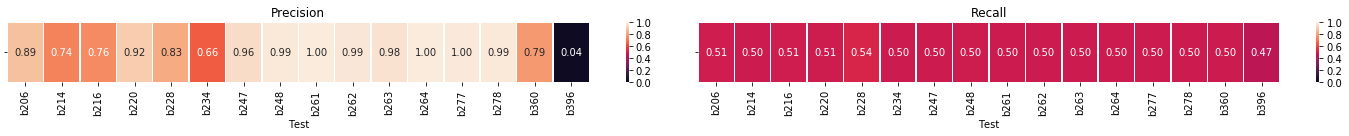

In [72]:
def kfold_as_df(data):
    rows, tiles = [], sorted(list(data.keys()))
    for rname in tiles:
        row = data[rname].copy()
        row.update({"Tile": rname}) 
        rows.append(row)
    df = pd.DataFrame(rows)
    df = df.set_index("Tile")
    return df.T

def kfold_heatmap(ax, results, fp):
    cmap = sns.cm.rocket
    
    fix_recall, fix_precs, fix_thresholds = {}, {}, {}
    for r in results:
        train_name, test_name = r["train_name"], r["test_name"]
        
        if train_name not in fix_recall:
            fix_recall[train_name] = {}
            fix_precs[train_name] = {}
            fix_thresholds[train_name] = {}
            
        precs, recalls, probs = r.prec_rec_curve
        
        idx = nearest(recalls, fp)
        
        fix_recall[train_name][test_name] = recalls[idx]
        fix_precs[train_name][test_name] = precs[idx]
        fix_thresholds[train_name][test_name] = probs[idx]
#     return fix_precs
        
    fix_precs = kfold_as_df(fix_precs)
    fix_recall = kfold_as_df(fix_recall)
    
    sns.heatmap(fix_precs, annot=True, fmt='.2f',  linewidths=.5, ax=ax[0], cmap=cmap, center=.5, vmin=0., vmax=1.)
    ax[0].set_xlabel("Test")
    ax[0].set_title(u"Precision".format(fp))
    
    sns.heatmap(fix_recall, annot=True, fmt='.2f', linewidths=.5, ax=ax[1], cmap=cmap, center=.5, vmin=0., vmax=1.)
    ax[1].set_xlabel("Test")
    ax[1].set_title(u"Recall".format(fp))


fig, axs = plt.subplots(1, 2, figsize=(20, 2))
kfold_heatmap(axs, kfolds_results, FIXED_RECALL)

axs[0].set_yticklabels([""])
axs[1].set_yticklabels([""])
    
fig.tight_layout()
fig.savefig("plots/s_kfolds/kfolds_heatmap.pdf")

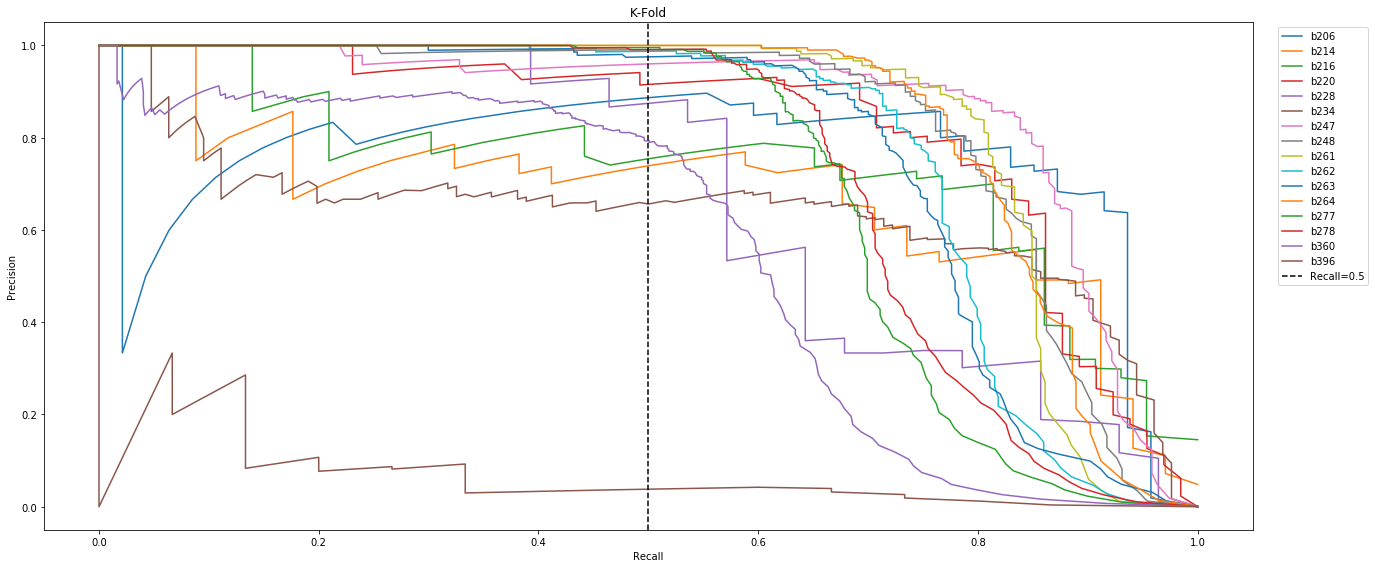

In [100]:
def kfold_plot_prec_roc_curve(ax, train_name, results):
    for r in results:
        if r.train_name == train_name:
            ax.plot(r.prec_rec_curve[1], r.prec_rec_curve[0], label=train_name)
            break
    ax.set_title("K-Fold")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")

fig, ax = plt.subplots(1, 1, figsize=(19, 8))
for t in data.keys():
    kfold_plot_prec_roc_curve(ax, train_name=t, results=kfolds_results)

ax.axvline(FIXED_RECALL, ls="--", color="k", label=f"Recall={FIXED_RECALL}")

lgd = ax.legend(bbox_to_anchor=(1.1, 1))

fig.tight_layout()
fig.savefig("plots/s_kfolds/kfolds_curves.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

## Using K-fold to check another tile

In [10]:
def get_fix_threshold(results, recall):
    fix_thresholds = {}
    for r in results:
        train_name = r["train_name"]
        
        if train_name not in fix_thresholds:
            fix_thresholds[train_name] = {}
            
        precs, recalls, probs = r.prec_rec_curve
        
        idx = nearest(recalls, recall)
        
        fix_thresholds[train_name] = probs[idx]
    return fix_thresholds
    
thresholds = get_fix_threshold(kfolds_results, FIXED_RECALL)
thresholds

{'b206': 0.45999999999999996,
 'b214': 0.33599999999999997,
 'b216': 0.41000000000000003,
 'b220': 0.542,
 'b228': 0.29000000000000004,
 'b234': 0.41600000000000004,
 'b247': 0.6639999999999999,
 'b248': 0.642,
 'b261': 0.648,
 'b262': 0.5820000000000001,
 'b263': 0.552,
 'b264': 0.616,
 'b277': 0.43200000000000005,
 'b278': 0.488,
 'b360': 0.19199999999999995,
 'b396': 0.016000000000000014}

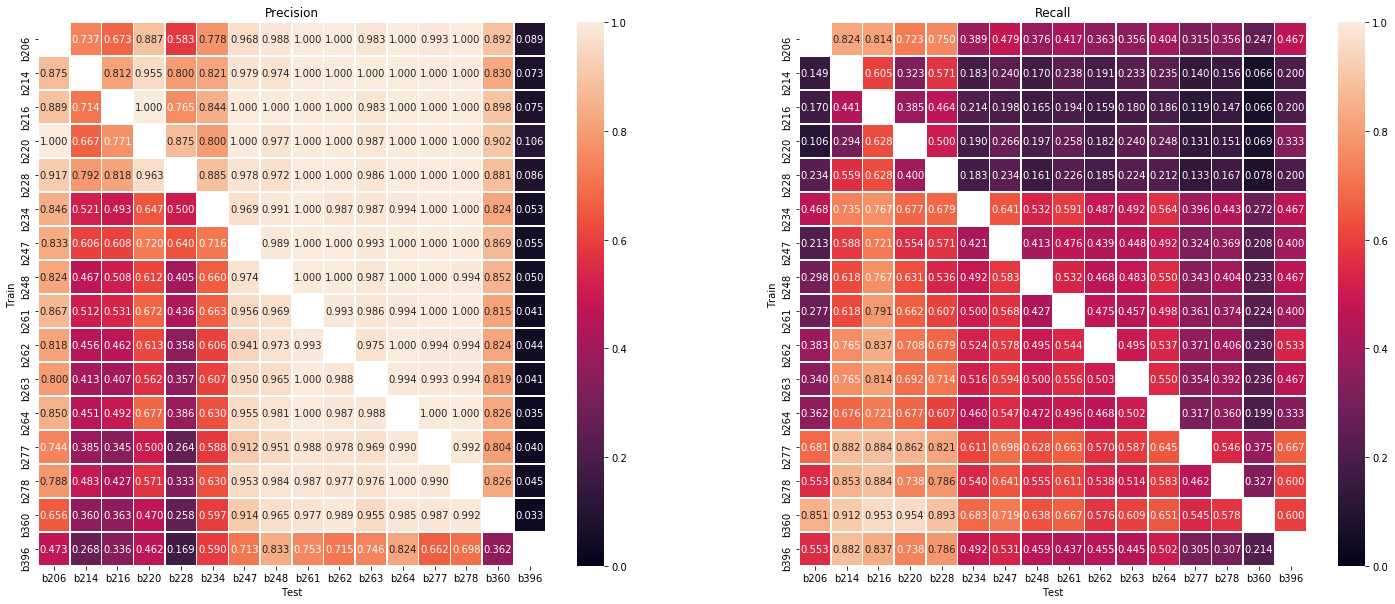

In [101]:
def all_as_df(data):
    rows, tiles = [], sorted(list(data.keys()))
    for rname in tiles:
        row = data[rname].copy()
        row.update({"Train": rname}) 
        rows.append(row)
    df = pd.DataFrame(rows)
    df = df.set_index("Train")[tiles]
    return df

def all_heatmap(ax, results):
    cmap = sns.cm.rocket
    
    fix_recall, fix_precs = {}, {}
    for r in results:
#         return r
        train_name, test_name = r["train_name"], r["test_name"]
        kfold_thrs = thresholds[r.train_name]
        
        if train_name not in fix_recall:
            fix_recall[train_name] = {}
            fix_precs[train_name] = {}
            
        precs, recalls, probs = r.prec_rec_curve
        
        idx = nearest(probs, kfold_thrs)
        
        fix_recall[train_name][test_name] = recalls[idx]
        fix_precs[train_name][test_name] = precs[idx]
        
    fix_precs = all_as_df(fix_precs)
    fix_recall = all_as_df(fix_recall)
    
    sns.heatmap(fix_precs, annot=True, fmt='.3f',  linewidths=.5, ax=ax[0], cmap=cmap, center=.5, vmin=0., vmax=1.)
    ax[0].set_xlabel("Test")
    ax[0].set_title(u"Precision")
    
    sns.heatmap(fix_recall, annot=True, fmt='.3f', linewidths=.5, ax=ax[1], cmap=cmap, center=.5, vmin=0., vmax=1.)
    ax[1].set_xlabel("Test")
    ax[1].set_title(u"Recall")

fig, axes = plt.subplots(1, 2, figsize=(25, 10))


r = heatmap(axes, all_results)
fig.savefig("plots/s_kfolds/all_withkfolds_heatmap.pdf", bbox_inches='tight')

In [148]:
from matplotlib import cm 

def make_all_kfold_curves(*, axes, fig, tiles, all_results, alpha=1, nolegend=False):
    
    cmap = cm.get_cmap("tab20")

    colors = dict(zip(tiles, cmap(np.linspace(0, 1, (len(tiles))))))
    labels = set()

    def plot_prec_roc_curve(ax, train_name, test_name, all_results, wp_label, thresholds):
        color = colors[train_name]
        for r in all_results:
            if r.test_name == test_name and r.train_name == train_name:
                label = train_name
                if label not in labels:
                    labels.add(label)
                else:
                    label = "__nolegend__"

                kfold_thrs = thresholds[train_name]

                precs, recalls, probs = r.prec_rec_curve
                idx = nearest(probs, kfold_thrs)

                ax.plot(recalls, precs, label=label, color=color, alpha=alpha)
                ax.plot(recalls[idx], precs[idx], color="r", marker="o", label=wp_label, alpha=alpha)
                break
        ax.set_title("Test {}".format(test_name))
        ax.set_xlabel("Recall")
        ax.set_ylabel("Precision")
    
    axes = it.chain(*axes)
    tiles = list(sorted(tiles))
    by_tile = {t: next(axes) for t in tiles}
    
    lasts = tuple(tiles[-2:])
    
    for train_name in sorted(tiles):
        for test_name in tiles:
            if train_name == sorted(test_name):
                continue
            ax = by_tile[train_name]
            wp_label = "Selected P-R" if (test_name, train_name) == lasts else "__no_legend__"
            plot_prec_roc_curve(ax, test_name, train_name, all_results, wp_label, thresholds)
    
    if not nolegend:
        fig.legend(loc=7, bbox_to_anchor=(1.05, 0.5))
    fig.tight_layout()
    return fig, by_tile
    
    
fig, axes = plt.subplots(4, 4, figsize=(18, 18))
make_all_kfold_curves(axes=axes, fig=fig, tiles=tiles, all_results=all_results);
plt.close()

## Ensembles

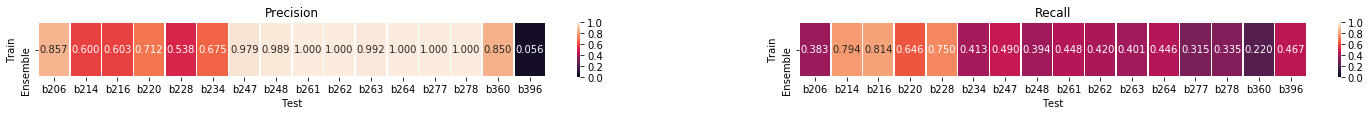

In [102]:
def grouped(clfs):
    groups = {}
    for tile in tiles:
        groups[tile] = [c for c in clfs if c.test_name == tile]
    return groups

def ensemble(grouped):
    results = []
    for t, g in grouped.items():
        y_tests = g[0].real_cls
        
        probabilities = (np.sum([e.probabilities for e in g], axis=0) / len(g))
        
        fpr, tpr, thresholds = metrics.roc_curve(
            y_tests, 1.-probabilities[:,0], pos_label=1)
        prec_rec_curve = metrics.precision_recall_curve(
            y_tests, 1.- probabilities[:,0], pos_label=1)

        roc_auc = metrics.auc(fpr, tpr)

        result = Container({
            "idx": 0,
            "clf_name": "RF",
            "train_name": "Ensemble",
            "test_name": t,
            'fpr': fpr,
            'tpr': tpr,
            'thresh': thresholds,
            'roc_auc': roc_auc,
            'prec_rec_curve': prec_rec_curve,
            'real_cls': y_tests,
            'predictions': None,
            'probabilities': probabilities,
            'confusion_matrix': None})
        results.append(result)
    return results

def as_edf(data):
    rows, tiles = [], sorted(list(data.keys()))
    for rname in tiles:
        row = data[rname].copy()
        row.update({"Train": rname}) 
        rows.append(row)
    df = pd.DataFrame(rows)
    df = df.set_index("Train")
    return df

def ensemble_heatmap(ax, results):
    cmap = sns.cm.rocket
    
    fix_recall, fix_precs = {}, {}
    for r in results:
#         return r
        train_name, test_name = r["train_name"], r["test_name"]
        efold_thrs = np.average([v for k, v in thresholds.items() if k != train_name])
        
        if train_name not in fix_recall:
            fix_recall[train_name] = {}
            fix_precs[train_name] = {}
            
        precs, recalls, probs = r.prec_rec_curve
        
        idx = nearest(probs, efold_thrs)
        
        fix_recall[train_name][test_name] = recalls[idx]
        fix_precs[train_name][test_name] = precs[idx]
    
    fix_precs = as_edf(fix_precs)
    fix_recall = as_edf(fix_recall)
    
    sns.heatmap(fix_precs, annot=True, fmt='.3f',  linewidths=.5, ax=ax[0], cmap=cmap, center=.5, vmin=0., vmax=1.)
    ax[0].set_xlabel("Test")
    ax[0].set_title(u"Precision")
    
    sns.heatmap(fix_recall, annot=True, fmt='.3f', linewidths=.5, ax=ax[1], cmap=cmap, center=.5, vmin=0., vmax=1.)
    ax[1].set_xlabel("Test")
    ax[1].set_title(u"Recall")

fig, axes = plt.subplots(1, 2, figsize=(25, 1))

grouped = grouped(full_clfs)
ensemble = ensemble(grouped)
ensemble_heatmap(axes, ensemble)
fig.savefig("plots/s_kfolds/ensemble_heatmap.pdf", bbox_inches='tight')

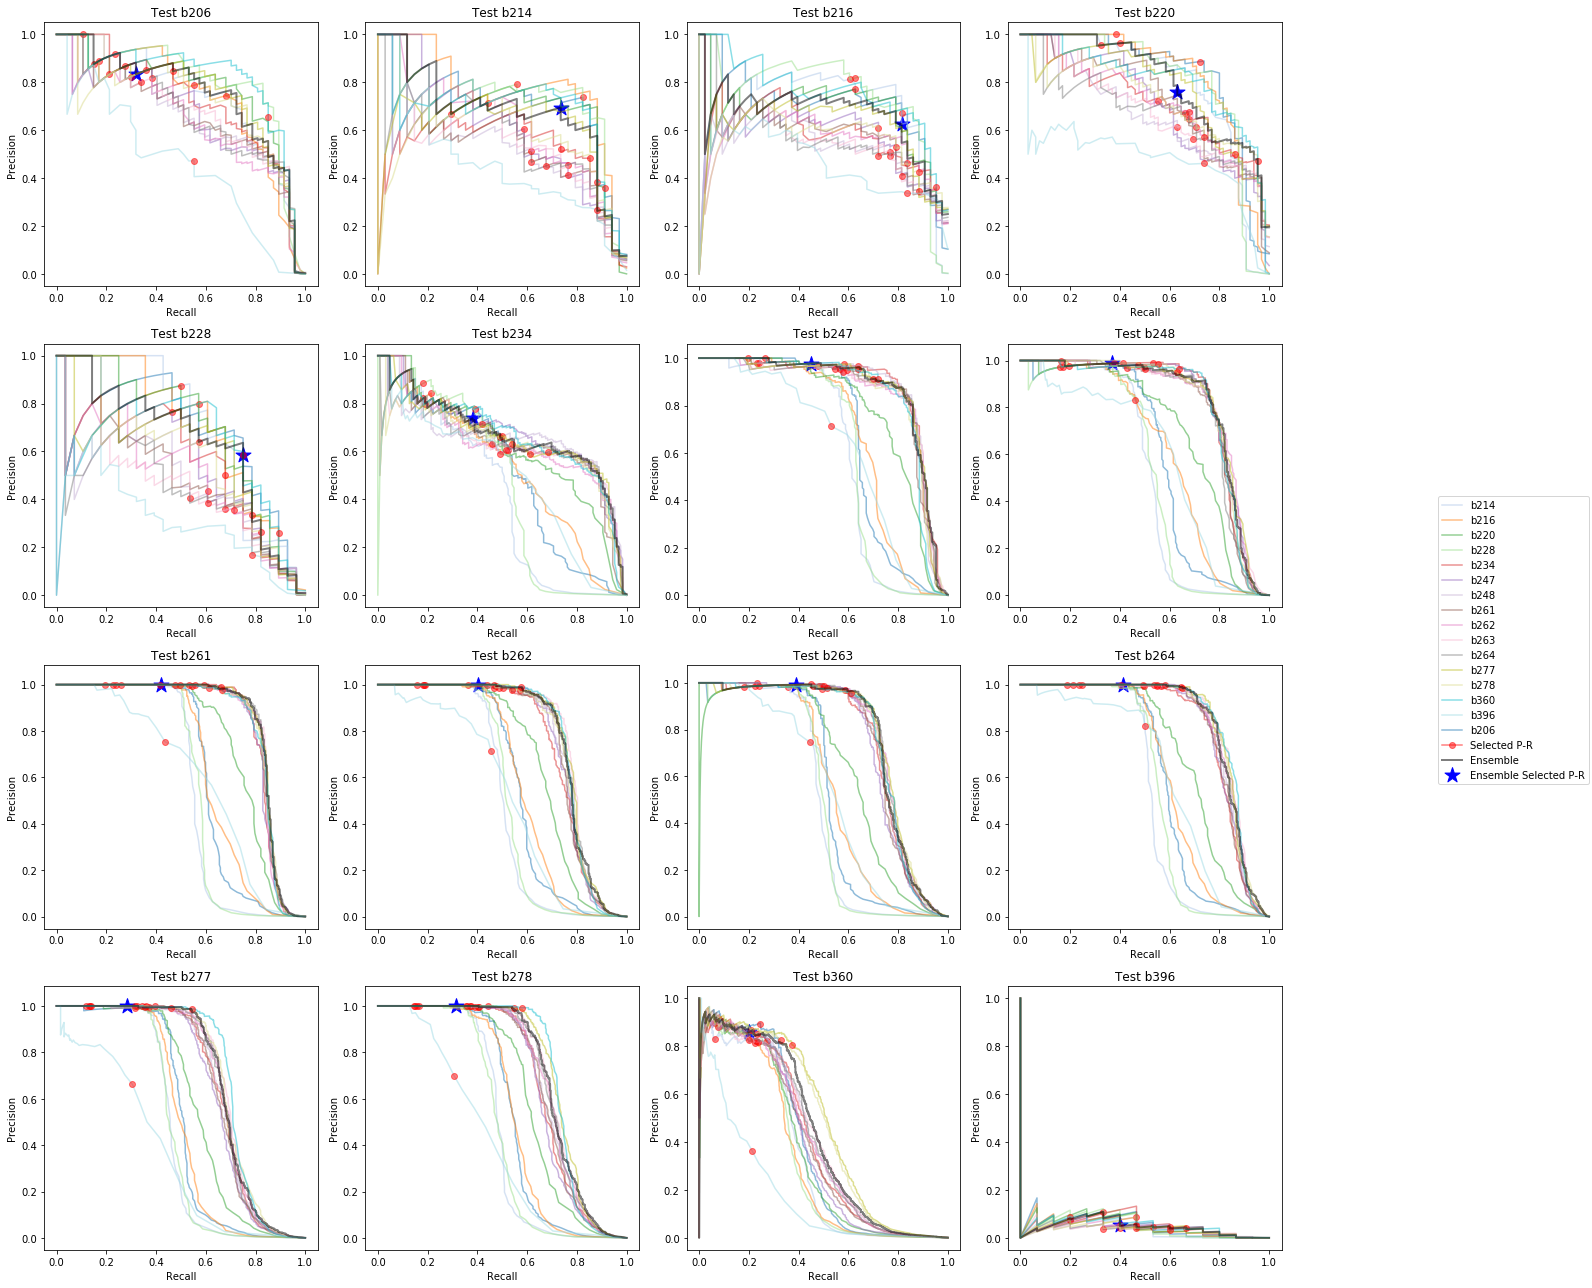

In [170]:
def ensemble_curve():
    fig, axes = plt.subplots(4, 4, figsize=(18, 18))
    fig, by_tile = make_all_kfold_curves(
        axes=axes, fig=fig, tiles=sorted(tiles), all_results=all_results, alpha=.5, nolegend=True);
    
    for r in ensemble:
        ax = by_tile[r.test_name]
        
        efold_thrs = np.average([v for k, v in thresholds.items() if k != train_name])
        
        precs, recalls, probs = r.prec_rec_curve
        idx = nearest(probs, efold_thrs)
        
        fix_recall = recalls[idx]
        fix_precs = precs[idx]
        
        legend_curve = "Ensemble" if r == ensemble[-1] else "_nolegend_"
        legend_wp = "Ensemble Selected P-R" if r == ensemble[-1] else "_nolegend_"
        ax.plot(recalls, precs, color="k", linewidth=2, label=legend_curve, alpha=.5)
        ax.scatter(fix_recall, fix_precs, marker="*", color="b", s=250, label=legend_wp)
        
    lgd = fig.legend(loc=7, bbox_to_anchor=(1.23, 0.5))
    fig.tight_layout()
    return axes, lgd
        

axes, lgd = ensemble_curve()
fig.savefig("plots/s_kfolds/ensemble_curves.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

In [98]:
def to_latex():
    rows = []
    sizes = 0
    rrs = 0
    unks = 0
    for tile, df in data.items():
        rr = np.sum(df.cls == 1)
        unk = np.sum(df.cls == 0)
        prop = rr / len(df)
        rows.append({
            "Tile": tile,
            "Size": len(df),
            "RRL": rr,
            "Unknow": unk,
            "% R": f"{prop * 100:.3f}%"
        })
        sizes +=  len(df)
        rrs +=  rr
        unks += unk
        
    props = rrs/sizes
    rows.append({
        "Tile": "Total",
        "Size": sizes,
        "RRL": rrs,
        "Unknow": unks,
        "% R": f"{props * 100:.3f}%"
        
    })
    df = pd.DataFrame(rows)
    return df.to_latex(index=False)
print(to_latex())

\begin{tabular}{lrrrl}
\toprule
  Tile &     Size &   RRL &   Unknow &     \% R \\
\midrule
  b206 &   157825 &    47 &   157778 &  0.030\% \\
  b214 &   149557 &    34 &   149523 &  0.023\% \\
  b216 &   168996 &    43 &   168953 &  0.025\% \\
  b220 &   209798 &    65 &   209733 &  0.031\% \\
  b228 &   199853 &    28 &   199825 &  0.014\% \\
  b234 &   293013 &   126 &   292887 &  0.043\% \\
  b247 &   406386 &   192 &   406194 &  0.047\% \\
  b248 &   417839 &   218 &   417621 &  0.052\% \\
  b261 &   555693 &   252 &   555441 &  0.045\% \\
  b262 &   573873 &   314 &   573559 &  0.055\% \\
  b263 &   568110 &   317 &   567793 &  0.056\% \\
  b264 &   595234 &   307 &   594927 &  0.052\% \\
  b277 &   718567 &   429 &   718138 &  0.060\% \\
  b278 &   742153 &   436 &   741717 &  0.059\% \\
  b360 &   939110 &   669 &   938441 &  0.071\% \\
  b396 &   486639 &    15 &   486624 &  0.003\% \\
 Total &  7182646 &  3492 &  7179154 &  0.049\% \\
\bottomrule
\end{tabular}



In [85]:
pd.DataFrame.set_index?

Signature:
pd.DataFrame.set_index(
    self,
    keys,
    drop=True,
    append=False,
    inplace=False,
    verify_integrity=False,
)
Docstring:
Set the DataFrame index using existing columns.

Set the DataFrame index (row labels) using one or more existing
columns or arrays (of the correct length). The index can replace the
existing index or expand on it.

Parameters
----------
keys : label or array-like or list of labels/arrays
    This parameter can be either a single column key, a single array of
    the same length as the calling DataFrame, or a list containing an
    arbitrary combination of column keys and arrays. Here, "array"
    encompasses :class:`Series`, :class:`Index`, ``np.ndarray``, and
    instances of :class:`~collections.abc.Iterator`.
drop : bool, default True
    Delete columns to be used as the new index.
append : bool, default False
    Whether to append columns to existing index.
inplace : bool, default False
    Modify the DataFrame in place (do not create a